# Initialization

Import of packages and function definitions

In [1]:
# Google Earth Engine packages
import ee
import geemap

# other packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#Define a function to plot the digital elevation model
def plotFigure(data, label, cmap='Blues'):
    plt.figure(figsize=(12,10))
    plt.imshow(data, extent=grid.extent, cmap=cmap)
    plt.colorbar(label=label)
    plt.grid()
    

# constants
ee_img = 'Image'
ee_ico = 'ImageCollection'

Initializtion of Google Earth Engine (GEE). When using it for the first time on this machine, you need to authenticate first. When using <code>mybinder.org</code> you need to authenticate everytime a new session has been launched. **Copy the generated token and paste it into the input field to proceed**.

Official Google Help Guide for <code>ee.Authenticate()</code>:

> Prompts you to authorize access to Earth Engine via OAuth2.
>
> Directs you to a authentication page on the Code Editor server at code.earthengine.google.com/client-auth. You will need to pick a Cloud Project to hold your developer configuration (OAuth Client). This can be the same Cloud Project that you already use in the Code Editor, if you have not set up an OAuth client on the project already.
>
> The setup page also lets you choose to make the notebook access read-only. This is recommended if you are running a notebook with code that you didn't write and which may be malicious. Any operations which try to write data will fail.
>
> The credentials obtained by ee.Authenticate() will be written to a persistent token stored on the local machine. ee.Initialize() will automatically use the persistent credentials, if they exist. To use service account credentials
>
> Source: https://developers.google.com/earth-engine/apidocs/ee-authenticate

In [2]:
# initialize GEE at the beginning of session
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()         # authenticate when using GEE for the first time
    ee.Initialize()

Read from `config.ini` file:

- input/output folders
- filename (DEM, GeoPackage)
- coordinated of discharge point
- used DEM
- show/hide GEE map

In [3]:
import configparser
import ast

# read local config.ini file
config = configparser.ConfigParser()
config.read('config.ini')

# get file config from config.ini
output_folder = config['FILE_SETTINGS']['DIR_OUTPUT']
filename = output_folder + config['FILE_SETTINGS']['DEM_FILENAME']
output_gpkg = output_folder + config['FILE_SETTINGS']['GPKG_NAME']

# get used GEE DEM, coords and other settings
dem_config = ast.literal_eval(config['CONFIG']['DEM'])
y, x = ast.literal_eval(config['CONFIG']['COORDS'])
show_map = config.getboolean('CONFIG','SHOW_MAP')

# print config data
print(f'Used DEM: {dem_config[3]}')
print(f'Coordinates of discharge point: Lat {y}, Long {x}')

Used DEM: MERIT 30m
Coordinates of discharge point: Lat 41.994671, Long 70.636229


# Start GEE and download DEM

Start with base map if enabled in `config.ini`

In [4]:
if show_map:
    Map = geemap.Map()
    display(Map)
else:
    print("Map view disabled in config.ini")

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Load selected DEM from GEE catalog and add as layer to map

In [5]:
if dem_config[0] == ee_img:
    image = ee.Image(dem_config[1])
elif dem_config[0] == ee_ico:
    image = ee.ImageCollection(dem_config[1]).select(dem_config[2]).mosaic()

if show_map:
    srtm_vis = { 'bands': dem_config[2],
                 'min': 0,
                 'max': 6000,
                'palette': ['000000', '478FCD', '86C58E', 'AFC35E', '8F7131','B78D4F', 'E2B8A6', 'FFFFFF']
               }

    Map.addLayer(image, srtm_vis, dem_config[3], True, 0.7)

Add configured discharge point to map and automatically draw box with **50km** in all directions. 

**<font color="red">Attention!</font>** Please check whether automatically added box seems reasonable. Alternatively, a manual box can be drawn which will be considered in the next step for the catchment deliniation. **The catchment area will be cropped if the selected box is too small.**

In [6]:
point = ee.Geometry.Point(x,y)
box = point.buffer(50000).bounds()

if show_map:
    Map.addLayer(point,{'color': 'blue'},'Discharge Point')
    Map.addLayer(box,{'color': 'grey'},'Catchment Area', True, 0.7)
    Map.centerObject(box, zoom=9)

Discharge point (marker) and box (polygon/rectangle) can be added manually to the map above. If features have been drawn, they will overrule the configured discharge point and automatically created box.

In [25]:
if show_map:
    for feature in Map.draw_features:
        f_type = feature.getInfo()['geometry']['type']
        if f_type == 'Point':
            point = feature.geometry()
            print("Manually set pouring point will be considered")
        elif f_type == 'Polygon':
            box = feature.geometry()
            print("Manually drawn box will be considered")

Manually drawn box will be considered
Manually drawn box will be considered
Manually drawn box will be considered


Export DEM as .tif file to output folder.

In [26]:
geemap.ee_export_image(image, filename=filename, scale=30, region=box, file_per_band=False)

Generating URL ...
Please wait ...
Data downloaded to C:\Python\matilda_edu\output\dem_gee.tif


# Catchment deliniation

Use <code>pysheds</code> module to determine catchment area for discharge point. The result will be a raster.

In [27]:
%%time

# GIS packages
from pysheds.grid import Grid
import fiona

# load DEM
DEM_file = filename
grid = Grid.from_raster(DEM_file)
dem = grid.read_raster(DEM_file)

CPU times: total: 46.9 ms
Wall time: 104 ms


In [21]:
%%time

# Fill depressions in DEM
flooded_dem = grid.fill_depressions(dem)
# Resolve flats in DEM
inflated_dem = grid.resolve_flats(flooded_dem)

# Specify directional mapping
#N    NE    E    SE    S    SW    W    NW
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
# Compute flow directions
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)
#catch = grid.catchment(x=x, y=y, fdir=fdir, dirmap=dirmap, xytype='coordinate')
# Compute accumulation
acc = grid.accumulation(fdir)
# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))
# Delineate the catchment
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, xytype='coordinate')
# Clip the DEM to the catchment
grid.clip_to(catch)
clipped_catch = grid.view(catch)

CPU times: total: 2.91 s
Wall time: 5.01 s


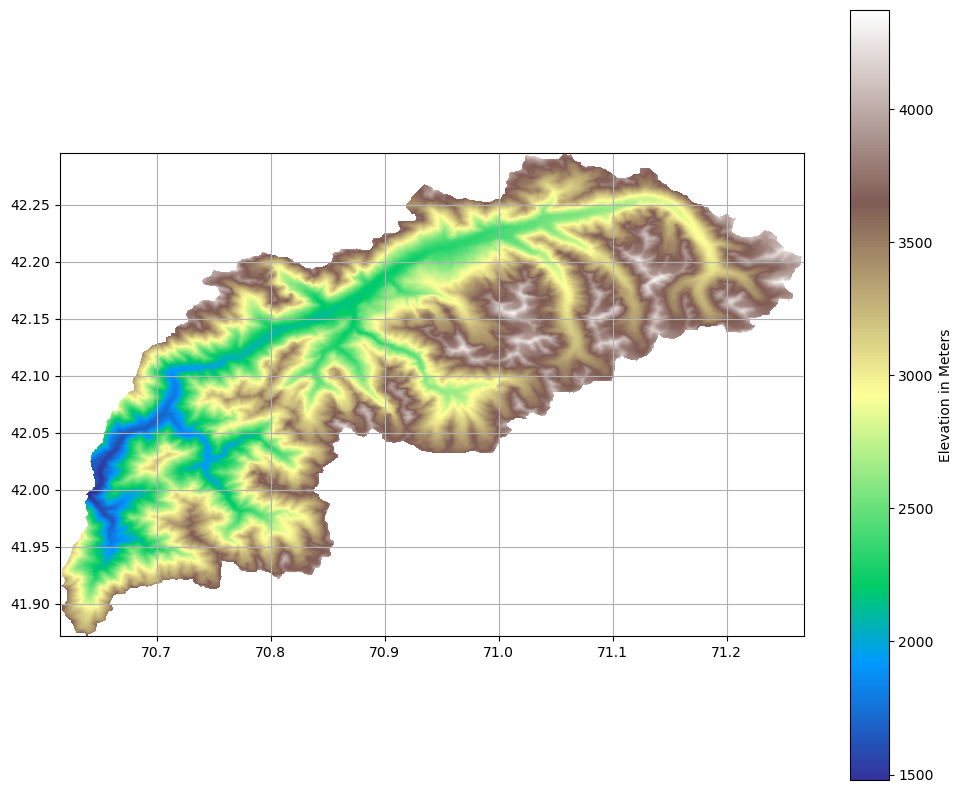

In [22]:
demView = grid.view(dem, nodata=np.nan)
plotFigure(demView,'Elevation in Meters',cmap='terrain')
plt.show()

Convert catchment raster to polygon and save to output folder as geopackage. 

In [23]:
from shapely.geometry import Polygon
import pyproj
from shapely.geometry import shape
from shapely.ops import transform

# Create shapefile and save it
shapes = grid.polygonize()

schema = {
    'geometry': 'Polygon',
    'properties': {'LABEL': 'float:16'}
}

catchment_shape = {}
layer_name = 'catchment_orig'
with fiona.open(output_gpkg, 'w',
                #driver='ESRI Shapefile',#
                driver='GPKG',
                layer=layer_name,
                crs=grid.crs.srs,
                schema=schema) as c:
    i = 0
    for shape, value in shapes:
        catchment_shape = shape
        rec = {}
        rec['geometry'] = shape
        rec['properties'] = {'LABEL' : str(value)}
        rec['id'] = str(i)
        c.write(rec)
        i += 1 

print(f"Layer '{layer_name}' added to GeoPackage '{output_gpkg}'\n")
        
catchment_bounds = [int(np.nanmin(demView)),int(np.nanmax(demView))]
ele_cat = float(np.nanmean(demView))
print(f"Catchment elevation is between {catchment_bounds[0]} m and {catchment_bounds[1]} m")
print(f"Mean catchment elevation is {ele_cat:.2f} m")

Layer 'catchment_orig' added to GeoPackage 'output/catchment_data.gpkg'

Catchment elevation is between 1480 m and 4374 m
Mean catchment elevation is 3112.40 m


Add catchment area to interactive map and calculate area with GEE. Please scroll up to see the results on the map.

In [24]:
catchment = ee.Geometry.Polygon(catchment_shape['coordinates'])
if show_map:
    Map.addLayer(catchment, {}, 'Catchment')

catchment_area = catchment.area().divide(1000*1000).getInfo()
print(f"Catchment area is {catchment_area:.2f} km²")

Catchment area is 1107.26 km²


**<font color="red">Attention!</font>** Please check that there is some buffer between the catchment area and the used box. If the catchment area is close to the box outline, please extent the box and repeat the DEM download and catchment deliniation.

# Determine glaciers in catchment area

The RGI 6.0 glacier outline inventory will be used to determine all glaciers that belong to the catchment area.

> The *Randolph Glacier Inventory (RGI 6.0)* is a global inventory of glacier outlines. It is supplemental to the Global Land Ice Measurements from Space initiative (GLIMS). Production of the RGI was motivated by the Fifth Assessment Report of the Intergovernmental Panel on Climate Change (IPCC AR5). Future updates will be made to the RGI and the GLIMS Glacier Database in parallel during a transition period. As all these data are incorporated into the GLIMS Glacier Database and as download tools are developed to obtain GLIMS data in the RGI data format, the RGI will evolve into a downloadable subset of GLIMS, offering complete one-time coverage, version control, and a standard set of attributes.
>
> Source: https://www.glims.org/RGI/

The RGI dataset is divided into 19 so called *first-order regions*. 

> RGI regions were developed under only three constraints: that theyshould resemble commonly recognized glacier domains,that together they should contain all of the world’s glaciers,and that their boundaries should be simple and readilyrecognizable on a map of the world. 
>
> Source (PDF): The Randolph Glacier Inventory: a globally complete inventory of glaciers. Available from: https://www.researchgate.net/publication/264125572_The_Randolph_Glacier_Inventory_a_globally_complete_inventory_of_glaciers 

![Map of the RGI regions; the red dots indicate the glacier locations and the blue circles the location of the 254 reference WGMS glaciers used by the OGGM calibration](https://docs.oggm.org/en/v1.2.0/_images/wgms_rgi_map.png)

In the first step, the RGI region of the catchment area must be determined to collect the right glacier outlines in a later step. Therefore, the RGI region outlines will be downloaded from the official website and spatially joined with the catchment area outline.

In [ ]:
import geopandas as gpd

# load catcment and RGI regions as DF
catchment = gpd.read_file(output_gpkg, layer='catchment_orig')
df_regions = gpd.read_file('https://www.glims.org/RGI/rgi60_files/00_rgi60_regions.zip')

For spatial operations and calculations it is crucial to use the correct projection. Otherwise, they could produce unexpected outputs. The relevant UTM zone and band for the catchment area can be automatically determined from the coordinates of the pouring point.

In [ ]:
import utm
from pyproj import CRS

utm_zone = utm.from_latlon(y, x)
print(f"UTM zone '{utm_zone[2]}', band '{utm_zone[3]}'")

# get CRS based on UTM
crs = CRS.from_dict({'proj':'utm', 'zone':utm_zone[2], 'south':False})

catchment_area = catchment.to_crs(crs).area[0] / 1000 / 1000
print(f"Catchment area (projected) is {catchment_area:.2f} km²")

Do spatial join between catchment area and RGI regions by using the determined projection. If the catchment area contains any glaciers, the corresponding RGI region should be determined in this step. 

In [ ]:
df_regions = df_regions.set_crs('EPSG:4326', allow_override=True)
catchment = catchment.to_crs('EPSG:4326')
df_regions_catchment = gpd.sjoin(df_regions, catchment, how="inner", predicate="intersects")

if len(df_regions_catchment.index) == 0:
    print('No area found for catchment')
    rgi_region = None
elif len(df_regions_catchment.index) == 1:
    rgi_region = df_regions_catchment.iloc[0]['RGI_CODE']
    print(f"Catchment belongs to RGI region {rgi_region} ({df_regions_catchment.iloc[0]['FULL_NAME']})")
else:
    print("Catchment belongs to more than one region. This use case is not yet supported.")
    display(df_regions_catchment)
    rgi_region = None

In the next step, the glacier inventory outlines for the determined RGI region will be downloaded. A spatial join is performed to determine all glacier outlines that intersect with the catchment area.

**Note**: Depending on the region and bandwidth, this might take some time. 

In [ ]:
%%time

import urllib.request
import re

if rgi_region != None:
    url = "https://www.glims.org/RGI/rgi60_files/"  # Replace with the URL of your web server
    html_page = urllib.request.urlopen(url)
    html_content = html_page.read().decode("utf-8")
    print('Reading Randolph Glacier Inventory 6.0 in GLIMS database')

    # Use regular expressions to find links to files
    pattern = re.compile(r'href="([^"]+\.zip)"')
    file_links = pattern.findall(html_content)


    for file in file_links:
        splits = file.split("_")
        if splits[0] != str(rgi_region):
            continue

        # starting scanning regions
        regionname = splits[0] + " (" + splits[2].split(".")[0] + ")"
        print(f'Locating glacier outlines in RGI Region {regionname}')

        # read zip into dataframe
        print('Loading shapefiles')
        rgi = gpd.read_file(url+file)
        if rgi.crs != catchment.crs:
            print("CRS adjusted")
            catchment = catchment.to_crs(rgi.crs)

        # check whether catchment intersects with glaciers of region
        rgi_catchment = gpd.sjoin(rgi,catchment,how='inner',predicate='intersects')
        if len(rgi_catchment.index) > 0:
            print(f'{len(rgi_catchment.index)} outlines loaded from RGI Region {regionname}\n')

Some glaciers do not belong to catchment but are intersecting the derived catchment area. Therefore, the percentage of the glacier will be calculated. The percentage value for each glacier will be printed.

In [ ]:
# intersects selects too many. calculate percentage of glacier area that is within catchment
rgi_catchment['rgi_area'] = rgi_catchment.to_crs(crs).area    
    
gdf_joined = gpd.overlay(catchment, rgi_catchment, how='union')
gdf_joined['area_joined'] = gdf_joined.to_crs(crs).area
gdf_joined['share_of_area'] = (gdf_joined['area_joined'] / gdf_joined['rgi_area'] * 100)

results = (gdf_joined
           .groupby(['RGIId', 'LABEL_1'])
           .agg({'share_of_area': 'sum'}))

display(results.sort_values(['share_of_area'],ascending=False))

The next step filters on the glaciers (incl./excl.) and adjusts the catchment area outline:

- include glaciers where >=50% of the area is part of the catchment -> extend catchment area by glacier outlines (if needed)
- exclude glaciers where <50% of the area is part of the catchment -> reduce catchment area by glaicer outlines (if needed)

In [ ]:
import pandas as pd
rgi_catchment_merge = pd.merge(rgi_catchment, results, on="RGIId")
rgi_in_catchment = rgi_catchment_merge.loc[rgi_catchment_merge['share_of_area'] >= 50]
rgi_out_catchment = rgi_catchment_merge.loc[rgi_catchment_merge['share_of_area'] < 50]
catchment_new = gpd.overlay(catchment, rgi_out_catchment, how='difference')
catchment_new = gpd.overlay(catchment_new, rgi_in_catchment, how='union')
catchment_new = catchment_new.dissolve()[['LABEL_1', 'geometry']]

print(f'Total number of determined glacier outlines: {len(rgi_catchment_merge)}')
print(f'Number of included glacier outlines (overlap >= 50%): {len(rgi_in_catchment)}')
print(f'Number of excluded glacier outlines (overlap < 50%): {len(rgi_out_catchment)}')

Write RGI-IDs of glaciers that belong to the catchment to CSV file `Glaciers_in_catchment.csv`.

In [ ]:
from pathlib import Path
Path(output_folder + 'RGI').mkdir(parents=True, exist_ok=True)

glacier_ids = pd.DataFrame(rgi_in_catchment)
glacier_ids['RGIId'] = glacier_ids['RGIId'].map(lambda x: str(x).lstrip('RGI60-'))
glacier_ids.to_csv(output_folder + 'RGI/' + 'Glaciers_in_catchment.csv', columns=['RGIId', 'GLIMSId'], index=False)
display(glacier_ids.head())

Do spatial calculations and determine final size of catchment area and glacierized area within catchment.

In [ ]:
catchment_new['area'] = catchment_new.to_crs(crs)['geometry'].area
area_glac = rgi_in_catchment.to_crs(crs)['geometry'].area

area_glac = area_glac.sum()/1000000
area_cat = catchment_new.iloc[0]['area']/1000000
cat_cent = catchment_new.to_crs(crs).centroid
lat = cat_cent.to_crs('EPSG:4326').y[0]

print(f"New catchment area is {area_cat:.2f} km²")
print(f"Glacierized catchment area is {area_glac:.2f} km²")

Export data to existing geopackage:
<ul>
    <li>RGI glaciers within catchment</li>
    <li>RGI glaciers outside catchment</li>
    <li>Adjusted catchment area based in RGI glacier outlines</li>
</ul>

In [ ]:
rgi_in_catchment.to_file(output_gpkg, layer='rgi_in', driver='GPKG')
print(f"Layer 'rgi_in' added to GeoPackage '{output_gpkg}'")

rgi_out_catchment.to_file(output_gpkg, layer='rgi_out', driver='GPKG')
print(f"Layer 'rgi_out' added to GeoPackage '{output_gpkg}'")

catchment_new.to_file(output_gpkg, layer='catchment_new', driver='GPKG')
print(f"Layer 'catchment_new' added to GeoPackage '{output_gpkg}'")

Add determined glacier outlines (in catchment) and new catchment area to map.

In [ ]:
c_new = geemap.geopandas_to_ee(catchment_new)
rgi = geemap.geopandas_to_ee(rgi_in_catchment)

if show_map:
    Map.addLayer(c_new, {'color': 'orange'}, "Catchment New")
    Map.addLayer(rgi, {'color': 'white'}, "RGI60")

Calculate mean catchment elevation in meters above sea level.

In [ ]:
ele_cat = image.reduceRegion(ee.Reducer.mean(),
                          geometry=c_new).getInfo()[dem_config[2]] 
print(f"Mean catchment elevation (adjusted) is {ele_cat:.2f} m.a.s.l.")

# Retrieve raster files for ice thickness and corresponding DEM raster files

The ice thickness of each glacier must be determined from raster files. Depending on the RGI IDs that are within the catchment area, the corresponding raster files will be downloaded from the server and stored in the output folder.
The thinkness raster files will be supported by DEM raster files for easier processing. 

In a first step, the relevant archives for DEM/thickness will be determined.

In [ ]:
def getArchiveNames(row):
    region = row['RGIId'].split('.')[0]
    id = (int(row['RGIId'].split('.')[1]) - 1) // 1000 + 1
    return f'ice_thickness_RGI60-{region}_{id}', f'dem_surface_DEM_RGI60-{region}_{id}'


# determine relevant .zip files for derived RGI IDs 
df_rgiids = pd.DataFrame(rgi_in_catchment['RGIId'].sort_values())
df_rgiids[['thickness', 'dem']] = df_rgiids.apply(getArchiveNames, axis=1, result_type='expand')
zips_thickness = df_rgiids['thickness'].drop_duplicates()
zips_dem = df_rgiids['dem'].drop_duplicates()

print(f'Thickness archives:\t{zips_thickness.tolist()}')
print(f'DEM archives:\t\t{zips_dem.tolist()}')

The archives are stored on a media server with specific references. Find the right resource references for the previously determined archives in the next step.

In [ ]:
from resourcespace import ResourceSpace

# use guest credentials to access media server
api_base_url = 'https://rs.cms.hu-berlin.de/matilda/api/?'  
private_key = '9a19c0cee1cde5fe9180c31c27a8145bc6f7a110cfaa3806ba262eb63d16f086' 
user = 'gast' 

myrepository = ResourceSpace(api_base_url, user, private_key)

# get resource IDs for each .zip file
refs_thickness = pd.DataFrame(myrepository.get_collection_resources(12))[['ref', 'file_size', 'file_extension', 'field8']]
refs_dem = pd.DataFrame(myrepository.get_collection_resources(21))[['ref', 'file_size', 'file_extension', 'field8']]

# reduce list of resources two required zip files 
refs_thickness = pd.merge(zips_thickness, refs_thickness, left_on='thickness', right_on='field8')
refs_dem = pd.merge(zips_dem, refs_dem, left_on='dem', right_on='field8')

In [ ]:
print(f'Thickness archive references:')
display(refs_thickness)
print(f'DEM archive references:')
display(refs_dem)

**Ice thickness**: download relevant archives from server and extract `.tif` files

In [ ]:
%%time

import requests
from zipfile import ZipFile
import io

cnt_thickness = 0
file_names_thickness = []
for idx, row in refs_thickness.iterrows():
    content = myrepository.get_resource_file(row['ref'])    
    with ZipFile(io.BytesIO(content), 'r') as zipObj:
        # Get a list of all archived file names from the zip
        listOfFileNames = zipObj.namelist()
        for rgiid in df_rgiids.loc[df_rgiids['thickness'] == row['field8']]['RGIId']:
            filename = 'RGI60-' + rgiid + '_thickness.tif'
            if filename in listOfFileNames:
                cnt_thickness += 1
                zipObj.extract(filename, output_folder+'RGI')
                file_names_thickness.append(filename)
            else:
                print(f'File not found: {filename}')
                
print(f'{cnt_thickness} files have been extracted (ice thickness)')

**DEM**: download relevant archives from server and extract `.tif` files

In [ ]:
%%time

cnt_dem = 0
file_names_dem = []
for idx,row in refs_dem.iterrows():   
    content = myrepository.get_resource_file(row['ref'])    
    with ZipFile(io.BytesIO(content), 'r') as zipObj:
        # Get a list of all archived file names from the zip
        listOfFileNames = zipObj.namelist()
        for rgiid in df_rgiids.loc[df_rgiids['dem']==row['field8']]['RGIId']:
            filename = f"surface_DEM_RGI60-{rgiid}.tif"
            if filename in listOfFileNames:
                cnt_dem += 1
                zipObj.extract(filename, output_folder+'RGI')
                file_names_dem.append(filename)
            else:
                print(f'File not found: {filename}')
                
print(f'{cnt_dem} files have been extracted (DEM)')

**<font color="red">Attention!</font>** Check that all files have been extracted to the output folder (i.e. no error message) and that the number of files matches the number of glaciers within the catchment area.

# Glacier profile creation
Overlay ice thickness and DEM tif for each glacier to create tuples

In [ ]:
from osgeo import gdal

df_all = pd.DataFrame()
if cnt_thickness != cnt_dem:
    print('Number of thickness raster files does not match number of DEM raster files!')
else:
    for idx, rgiid in enumerate(df_rgiids['RGIId']):
        if rgiid in file_names_thickness[idx] and rgiid in file_names_dem[idx]:
            file_list = [
                output_folder + 'RGI/' + file_names_thickness[idx],
                output_folder + 'RGI/' + file_names_dem[idx]
            ]
            array_list = []

            # Read arrays
            for file in file_list:
                src = gdal.Open(file)
                geotransform = src.GetGeoTransform() # Could be done more elegantly outside the for loop
                projection = src.GetProjectionRef()
                array_list.append(src.ReadAsArray())
                pixelSizeX = geotransform[1]
                pixelSizeY =-geotransform[5]                
                src = None
            
            df = pd.DataFrame()
            df['thickness'] = array_list[0].flatten()
            df['altitude'] = array_list[1].flatten()
            df_all = pd.concat([df_all, df])
        else:
            print(f'Raster files do not match for {rgiid}')

Remove all points with zero ice thickness and aggregate all points to 10m elevation zones.

Export result as CSV file `glacier_profile.csv`

In [ ]:
if len(df_all) > 0:
    df_all = df_all.loc[df_all['thickness'] > 0]
    df_all.sort_values(by=['altitude'],inplace=True)
    
    # get min/max altitude considering catchment and all glaciers
    alt_min = 10*int(min(catchment_bounds[0],df_all['altitude'].min())/10)
    alt_max = max(catchment_bounds[1],df_all['altitude'].max())+10
        
    # create bins in 10m steps
    bins = np.arange(alt_min, df_all['altitude'].max()+10, 10)
    
    # aggregate per bin and do some math
    df_agg = df_all.groupby(pd.cut(df_all['altitude'], bins))['thickness'].agg(count='size', mean='mean').reset_index()
    df_agg['Elevation'] = df_agg['altitude'].apply(lambda x: x.left)
    df_agg['Area'] = df_agg['count']*pixelSizeX*pixelSizeY / catchment_new.iloc[0]['area']
    df_agg['WE'] = df_agg['mean']*0.908*1000
    df_agg['EleZone'] = df_agg['Elevation'].apply(lambda x: 100*int(x/100))
    
    # delete empty elevation bands but keep at least one entry per elevation zone
    df_agg=pd.concat([df_agg.loc[df_agg['count']>0],
                      df_agg.loc[df_agg['count']==0].drop_duplicates(['EleZone'],keep='first')]
                    ).sort_index()
    
    df_agg.drop(['altitude', 'count', 'mean'], axis=1, inplace=True)
    df_agg = df_agg.replace(np.nan, 0)
    df_agg.to_csv(output_folder + 'glacier_profile.csv', header=True, index=False)
    print('Glacier profile for catchment successfully created!')
    display(df_agg)

Calculate average glacier elevation in meters above sea level.

In [ ]:
ele_glac = round(df_all.altitude.mean(), 2)
print(f'Average glacier elevation in the catchment: {ele_glac:.2f} m.a.s.l.')

# Store calculated values for other notebooks

Create a settings.yaml and store the relevant catchment information.

In [ ]:
import yaml

settings = {'area_cat': float(area_cat),
            'ele_cat': float(ele_cat),
            'area_glac': float(area_glac),
            'ele_glac': float(ele_glac),
            'lat': float(lat)
           }
with open(output_folder + 'settings.yml', 'w') as f:
    yaml.safe_dump(settings, f)

In [ ]:
display(pd.DataFrame(settings.items(),columns=['Parameter','Value']).set_index('Parameter'))

In [ ]:
%reset -f